In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

In [2]:
dir_path = os.path.join("database", "text_classification")

with open (os.path.join(dir_path, "en.json")) as f:
    data = json.load(f)
    df = pd.DataFrame(data)

df.head()

,text,label
0,Did a pain in the center of the chest ever occ...,chest_pain
1,Did those symptoms changes?,symptoms_changes
2,Did you experienced fainting?,fainting_symptoms
3,Did you faint?,fainting_symptoms
4,Did you had a cough with sputum?,cough_symptoms


In [3]:
df["label"].value_counts()

visit_reason              12
symptoms_start             9
greetings                  8
fever_symptoms             6
diseases_parents           6
surgeries                  5
symptoms_circumstances     5
chest_pain                 4
symptoms_changes           4
fainting_symptoms          4
diseases_personal          4
cough_symptoms             3
palpitations_symptoms      3
chronic_treatment          3
Name: label, dtype: int64

In [4]:
dir_path = os.path.join("database", "personas")

with open(os.path.join(dir_path, "en_personas.json")) as f:
    data = json.load(f)
    texts = []
    labels = []
    for persona in data:
        for dialog_entity in persona["dialog"]:
            if not "questions" in dialog_entity:
                print(dialog_entity)
            
            for question in dialog_entity["questions"]:
                texts.append(question)
                labels.append(dialog_entity["label"])
    df_persona = pd.DataFrame(
        {
            "text": texts,
            "label": labels
        }
    )
df_persona.head()

,text,label
0,What is the reason for the presentation at the...,visit_reason
1,When did the symptoms start?,symptoms_start
2,What are the circumstances of the onset of sym...,symptoms_circumstances
3,Were there any changes in symptoms from onset ...,symptoms_changes
4,Do you know of any illness that your mother or...,diseases_parents


In [5]:
counts = df_persona["label"].value_counts()
counts

greetings                 90
diseases_personal         18
chronic_treatment         16
visit_reason              15
symptoms_start            15
symptoms_circumstances    15
symptoms_changes          15
diseases_parents          15
surgeries                 15
chest_pain                15
fainting_symptoms         15
palpitations_symptoms     15
cough_symptoms            15
fever_symptoms            15
Name: label, dtype: int64

In [6]:
df_combined = pd.concat([df, df_persona], ignore_index=True)
label_to_idx = {label: idx for idx, label in enumerate(df_combined["label"].unique())}
label_to_idx

{'chest_pain': 0,
 'symptoms_changes': 1,
 'fainting_symptoms': 2,
 'cough_symptoms': 3,
 'surgeries': 4,
 'fever_symptoms': 5,
 'palpitations_symptoms': 6,
 'chronic_treatment': 7,
 'diseases_parents': 8,
 'diseases_personal': 9,
 'greetings': 10,
 'symptoms_start': 11,
 'symptoms_circumstances': 12,
 'visit_reason': 13}

In [7]:
df_combined["label_id"] = df_combined["label"].apply(lambda s: label_to_idx[s])
df_combined.head()

,text,label,label_id
0,Did a pain in the center of the chest ever occ...,chest_pain,0
1,Did those symptoms changes?,symptoms_changes,1
2,Did you experienced fainting?,fainting_symptoms,2
3,Did you faint?,fainting_symptoms,2
4,Did you had a cough with sputum?,cough_symptoms,3


In [8]:
train_df = df_combined.groupby("label").sample(10, random_state=42)
valid_df = df_combined.drop(train_df.index)

In [9]:
batch_size = 12

train_dataset = (tf.data.Dataset
                 .from_tensor_slices((train_df["text"], train_df["label_id"]))
                 .batch(batch_size))

valid_dataset = (tf.data.Dataset
                 .from_tensor_slices((valid_df["text"], valid_df["label_id"]))
                 .batch(batch_size))

In [10]:
VOCAB_SIZE = 10_000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE
)
encoder.adapt(df_combined["text"])

In [11]:
encoder(df_combined.loc[:3, "text"])

<tf.Tensor: shape=(4, 11), dtype=int64, numpy=
array([[ 19,  10,  39,   4,   2,  52,   5,   2,  34,  40,  43],
       [ 19,  98,   9,  41,   0,   0,   0,   0,   0,   0,   0],
       [ 19,   3, 120,  47,   0,   0,   0,   0,   0,   0,   0],
       [ 19,   3, 119,   0,   0,   0,   0,   0,   0,   0,   0]],
      dtype=int64)>

In [12]:
output_dim = 64
units = 64

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=output_dim,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units)),
    tf.keras.layers.Dense(len(label_to_idx)),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          8512      
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 14)                1806      
                                                        

In [13]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

In [15]:
epochs = 100

history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset
)

Epoch 1/100
12/12 [==============================] - 18s 474ms/step - loss: 2.6406 - sparse_categorical_accuracy: 0.0429 - val_loss: 2.6380 - val_sparse_categorical_accuracy: 0.1956
Epoch 2/100
12/12 [==============================] - 1s 85ms/step - loss: 2.6368 - sparse_categorical_accuracy: 0.1857 - val_loss: 2.6366 - val_sparse_categorical_accuracy: 0.1600
Epoch 3/100
12/12 [==============================] - 1s 82ms/step - loss: 2.6344 - sparse_categorical_accuracy: 0.2286 - val_loss: 2.6354 - val_sparse_categorical_accuracy: 0.1911
Epoch 4/100
12/12 [==============================] - 1s 80ms/step - loss: 2.6321 - sparse_categorical_accuracy: 0.2857 - val_loss: 2.6342 - val_sparse_categorical_accuracy: 0.2178
Epoch 5/100
12/12 [==============================] - 1s 79ms/step - loss: 2.6297 - sparse_categorical_accuracy: 0.3357 - val_loss: 2.6325 - val_sparse_categorical_accuracy: 0.3111
Epoch 6/100
12/12 [==============================] - 1s 79ms/step - loss: 2.6271 - sparse_categori

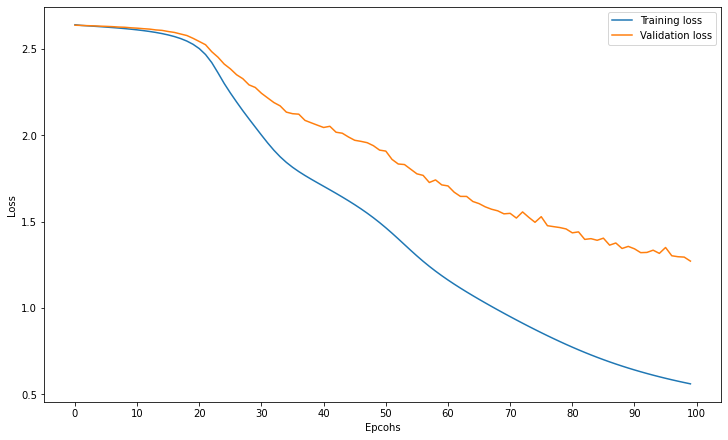

In [16]:
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)
ax.plot(history.history["loss"], label="Training loss")
ax.plot(history.history["val_loss"], label="Validation loss")
ax.set_xlabel("Epcohs")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, len(history.history["loss"]) + 1, 10))
ax.legend()
plt.savefig("loss.png")

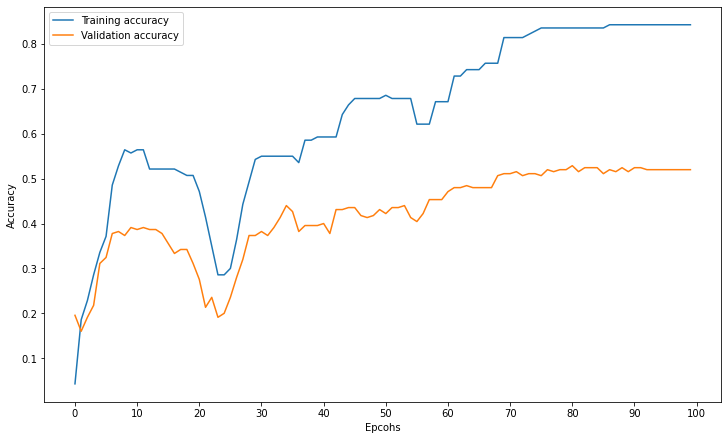

In [17]:
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)
ax.plot(history.history["sparse_categorical_accuracy"], label="Training accuracy")
ax.plot(history.history["val_sparse_categorical_accuracy"], label="Validation accuracy")
ax.set_xlabel("Epcohs")
ax.set_ylabel("Accuracy")
ax.set_xticks(np.arange(0, len(history.history["sparse_categorical_accuracy"]) + 1, 10))
ax.legend()
fig.savefig("accuracy.png")

In [18]:
metrics = model.evaluate(
    df_combined["text"].to_numpy(),
    df_combined["label_id"].to_numpy()
)

for metric_name, metric in zip(model.metrics_names, metrics):
    print(f"{metric_name:<8s}: {metric:.4f}")

12/12 [==============================] - 0s 31ms/step - loss: 0.9991 - sparse_categorical_accuracy: 0.6411
loss    : 0.9991
sparse_categorical_accuracy: 0.6411


In [19]:
predictions_probabilities = model.predict(df_combined["text"])
predictions = np.argmax(predictions_probabilities, axis=1)

y_true = df_combined["label_id"].to_numpy()
accuracy = accuracy_score(y_true, predictions)
precision = precision_score(y_true, predictions, average="macro")
recall = precision_score(y_true, predictions, average="macro")
f1score = f1_score(y_true, predictions, average="macro")

print(f"accuracy : {accuracy:.4f}")
print(f"precision: {precision:.4f}")
print(f"recall   : {recall:.4f}")
print(f"F1       : {f1score:.4f}")

12/12 [==============================] - 5s 25ms/step
accuracy : 0.6438
precision: 0.7206
recall   : 0.7206
F1       : 0.7405


C:\Users\Eduard\miniconda3\envs\licenta\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Eduard\miniconda3\envs\licenta\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


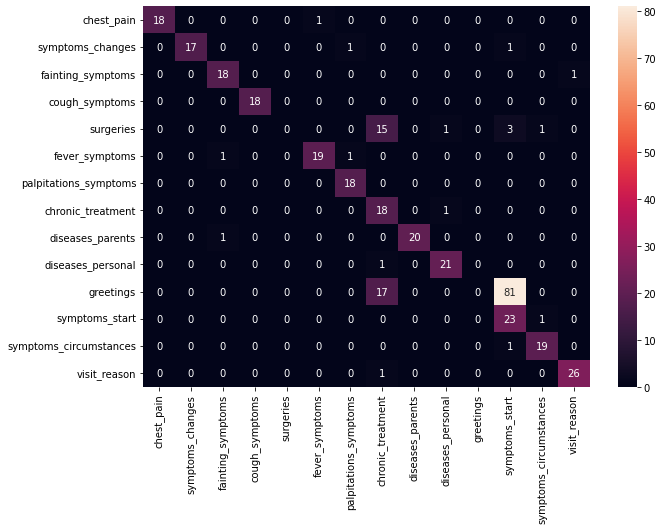

In [20]:
matrix = confusion_matrix(y_true, predictions)
index = label_to_idx.keys()
df = pd.DataFrame(matrix, index=index, columns=index)
plt.figure(figsize=(10, 7))
sns.heatmap(df, annot=True, fmt="d")
plt.savefig("confusion_matrix.png")

In [21]:
model.save("rnn")

INFO:tensorflow:Assets written to: rnn\assets


INFO:tensorflow:Assets written to: rnn\assets


In [22]:
# with open("label_to_idx.json", "w", encoding="utf-8") as f:
#     json.dump(label_to_idx, f)